<a href="https://colab.research.google.com/github/rennyatwork/CegepSteFoy_IA/blob/main/08_deep_learning/tp_01_v02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
#import tensorflow.keras.optimizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasRegressor
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
import keras as keras
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from keras.callbacks import ModelCheckpoint

In [3]:
#!pip install tensorflow

In [57]:
def get_df_from_csv(p_path, p_sep=',', p_print=True):
  df= pd.read_csv(p_path, sep= p_sep)
  if (p_print):
    print('---Head---')
    print(df.head())
    print('-- How many nulls? --')
    print(df.isna().sum())
  return df


In [58]:
## Augmented df
path_csv = "https://raw.githubusercontent.com/rennyatwork/CegepSteFoy_IA/main/08_deep_learning/data/AugmentedData_reduced.csv"
augmented_df = get_df_from_csv(path_csv, p_sep =",")

---Head---
   GameID  ScenarioID  HolesCompletedCount  Hole1  Hole2  Hole3  Hole4  Hole5  \
0       1           1                    0      0      0      0      0      0   
1       2           1                    0      0      0      0      0      0   
2       3           1                    0      0      0      0      0      0   
3       4           1                    0      0      0      0      0      0   
4       5           1                    0      0      0      0      0      0   

   Hole6  Hole7  ...  Hole10  Hole11  Hole12  Hole13  Hole14  Hole15  Hole16  \
0      0      0  ...       0       0       0       0       0       0       0   
1      0      0  ...       0       0       0       0       0       0       0   
2      0      0  ...       0       0       0       0       0       0       0   
3      0      0  ...       0       0       0       0       0       0       0   
4      0      0  ...       0       0       0       0       0       0       0   

   Hole17  Hole18  To

In [59]:
## Original df
path_csv = "https://raw.githubusercontent.com/rennyatwork/CegepSteFoy_IA/main/08_deep_learning/data/OriginalData.csv"
original_df = get_df_from_csv(path_csv, p_sep =",")

---Head---
   GameID  Hole1  Hole2  Hole3  Hole4  Hole5  Hole6  Hole7  Hole8  Hole9  \
0       1      4      6      5      4      6      5      5      3      5   
1       2      3      5      4      4      5      5      6      3      4   
2       3      5      4      6      4      7      4      5      3      5   
3       4      4      4      7      3      6      4      4      4      5   
4       5      4      7      6      4      5      4      5      3      4   

   Hole10  Hole11  Hole12  Hole13  Hole14  Hole15  Hole16  Hole17  Hole18  \
0       4       5       4       4       6       4       5       4       6   
1       5       5       5       4       5       3       4       3       4   
2       6       6       5       4       5       3       5       3       3   
3       7       5       7       4       6       3       6       3       4   
4       6       9       6       3       5       4       5       3       4   

   TotalScore  
0          85  
1          77  
2          83  
3    

In [60]:
## train test split
def get_train_test(pDf=original_df, p_var_y='TotalScore', p_test_size=0.2, p_random_state=25):
  dfX = pDf.drop(p_var_y, axis=1).values
  dfY = pDf[p_var_y]

  # Apply standardization to feature values
  scaler = StandardScaler()
  dfX_standardized = scaler.fit_transform(dfX)

  X_train, X_test, y_train, y_test = train_test_split(dfX, dfY, test_size=p_test_size, random_state=p_random_state)
  X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=p_test_size, random_state=p_random_state)

  return X_train, X_valid, X_test, y_train, y_valid, y_test


In [7]:
## create model
def create_model (p_learning_rate, p_dropout_rate, pDfX, p_nb_neuron_input=128, p_activation='relu'):
  model = Sequential()
  model.add(Dense(p_nb_neuron_input, input_dim=pDfX.shape[1], activation=p_activation))
  model.add(Dropout(p_dropout_rate))
  model.add(Dense(int(p_nb_neuron_input/2), activation=p_activation))
  model.add(Dropout(p_dropout_rate))
  model.add(Dense(int(p_nb_neuron_input/4), activation=p_activation))
  model.add(Dropout(p_dropout_rate))
  model.add(Dense(1))

  adam = Adam(lr = p_learning_rate)

  model.compile( loss='mean_squared_error', optimizer=adam, metrics=['mae'])
  return model


In [61]:
## build model (book HandsOn -on ML, Aurélien Géron)
def build_model (p_input_shape,
                 p_n_hidden=1,
                 p_n_neurons=30,
                 p_learning_rate=3e-3,
                 p_activation='relu'):
  model = Sequential()
  model.add(keras.layers.InputLayer(input_shape=p_input_shape))
  for layer in range(p_n_hidden):
    model.add(keras.layers.Dense(p_n_neurons, activation=p_activation))
    model.add(keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5))
    #keras.layers.BatchNormalization()
  model.add(keras.layers.Dense(1))
  optimizer = keras.optimizers.SGD(lr=p_learning_rate)

  #arr_metrics = ['mae', 'accuracy']
  arr_metrics = ['mae']

  model.compile(loss='mse', optimizer = optimizer, metrics=arr_metrics)
  return model

In [23]:
## getting train, test sets
X_train, X_valid, X_test, y_train, y_valid,  y_test = get_train_test()

In [24]:
model = create_model (0.01, 0.3, X_train)

In [42]:
def plot_graph(p_model_history):
    # Plot MAE
    plt.plot(p_model_history['mae'])
    plt.plot(p_model_history['val_mae'])

    # Plot loss
    plt.plot(p_model_history['loss'])
    plt.plot(p_model_history['val_loss'])

    # Add labels and legends for MAE and loss
    plt.legend(['train MAE', 'test MAE', 'train loss', 'test loss'], loc='upper right')
    plt.title('Model Metrics')
    plt.ylabel('Metrics')
    plt.xlabel('Epoch')
    plt.show()

    # Plot accuracy (if applicable)
    if 'accuracy' in p_model_history:
        plt.plot(p_model_history['accuracy'])
        plt.plot(p_model_history['val_accuracy'])

        # Add labels and legends for accuracy
        plt.legend(['train accuracy', 'test accuracy'], loc='upper right')
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.show()


In [11]:
def plot_graph_2(p_model_history, p_var_valid, p_var_test, p_arr_legend):
    # Plot MAE
    plt.plot(p_model_history[p_var_valid])
    plt.plot(p_model_history[p_var_test])

    ## Plot loss
    #plt.plot(p_model_history['loss'])
    #plt.plot(p_model_history['val_loss'])

    ## Add labels and legends for MAE and loss
    #plt.legend(['train MAE', 'test MAE', 'train loss', 'test loss'], loc='upper right')
    plt.legend(p_arr_legend, loc='upper right')
    plt.title('Model Metrics')
    plt.ylabel('Metrics')
    plt.xlabel('Epoch')
    plt.show()






In [25]:
def do_analysis(pModel, pXTrain, pYTrain, pXTest, pYTest,
                p_dropout_rate =0.3, p_learning_rate=0.01, p_epochs =30, p_batch_size=10,
                p_validation_split=0.2, p_verbose=True, p_plot_graph=1):

  ## we fit with train
  model_history = pModel.fit(pXTrain, pYTrain, batch_size=p_batch_size, epochs=p_epochs, validation_split = p_validation_split, verbose=1)

  ## we evaluate model's accuracy (use TEST vars, NOT TRAIN)
  score = pModel.evaluate(pXTest, pYTest, verbose=p_verbose)

  print("[Loss]: ", score[0])
  print("[Mean Abs Error]: ", score[1])

  if(p_plot_graph):
    #plot_graph(model_history.history)
    plot_graph_2(model_history.history, 'mae', 'val_mae', ['train MAE', 'test MAE'])
    plot_graph_2(model_history.history, 'loss', 'val_loss', ['train LOSS', 'test LOSS'])


Epoch 1/150
103/103 [==============================] - 2s 5ms/step - loss: 5465.9458 - mae: 58.9036 - val_loss: 3199.0105 - val_mae: 53.9353
Epoch 2/150
103/103 [==============================] - 0s 3ms/step - loss: 2341.6211 - mae: 41.3166 - val_loss: 1937.6277 - val_mae: 43.1675
Epoch 3/150
103/103 [==============================] - 0s 3ms/step - loss: 1598.5994 - mae: 32.5420 - val_loss: 1978.2440 - val_mae: 41.3132
Epoch 4/150
103/103 [==============================] - 0s 4ms/step - loss: 1210.4038 - mae: 28.4669 - val_loss: 1127.6884 - val_mae: 31.3424
Epoch 5/150
103/103 [==============================] - 0s 3ms/step - loss: 1088.4937 - mae: 26.8582 - val_loss: 757.9001 - val_mae: 25.5502
Epoch 6/150
103/103 [==============================] - 0s 3ms/step - loss: 932.5947 - mae: 24.7595 - val_loss: 1083.8917 - val_mae: 30.6156
Epoch 7/150
103/103 [==============================] - 0s 3ms/step - loss: 871.2529 - mae: 23.9642 - val_loss: 382.2331 - val_mae: 18.6781
Epoch 8/150
103/1

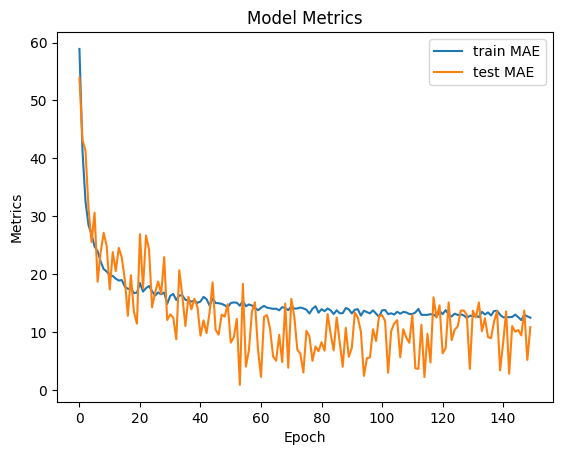

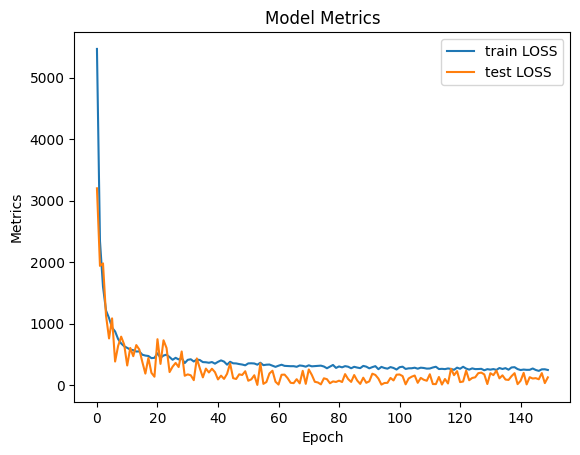

In [26]:
## Modele valuation
do_analysis(model, X_train, y_train, X_test, y_test, p_epochs=150, p_verbose=0)

In [62]:
# Split your data and define input_shape
input_shape = X_train.shape[1]  # Number of features

# Create the KerasRegressor with your build_model function
keras_reg = KerasRegressor(build_fn=build_model, p_input_shape=input_shape, p_n_hidden=1, p_n_neurons=30, p_learning_rate=3e-3, p_activation='relu')


<ipython-input-62-a7b188dfa79d>:5: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = KerasRegressor(build_fn=build_model, p_input_shape=input_shape, p_n_hidden=1, p_n_neurons=30, p_learning_rate=3e-3, p_activation='relu')


In [65]:
keras_reg.fit( X_train, y_train, epochs = 20,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

msa_test = keras_reg.score(X_test, y_test)
y_pred = keras_reg.predict(X_test)

# Calculate Mean Squared Error (MSE)
print('y_test: ', y_test.isna().sum())
dfYPred = pd.DataFrame(y_pred)
print('y_pred: ', dfYPred.isna().sum())
mse = mean_squared_error(y_test, y_pred)

# Calculate R-squared (Coefficient of Determination)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Epoch 1/20
40/40 [==============================] - 1s 7ms/step - loss: 990.6071 - mae: 17.8780 - val_loss: 53.8734 - val_mae: 5.9640
Epoch 2/20
40/40 [==============================] - 0s 3ms/step - loss: 51.9627 - mae: 5.9043 - val_loss: 6199.0952 - val_mae: 71.0397
Epoch 3/20
40/40 [==============================] - 0s 3ms/step - loss: 51.5624 - mae: 5.9208 - val_loss: 51.7615 - val_mae: 5.8475
Epoch 4/20
40/40 [==============================] - 0s 3ms/step - loss: 50.3384 - mae: 5.8218 - val_loss: 54.8492 - val_mae: 6.0373
Epoch 5/20
40/40 [==============================] - 0s 3ms/step - loss: 50.6671 - mae: 5.9013 - val_loss: 51.7757 - val_mae: 5.8766
Epoch 6/20
40/40 [==============================] - 0s 3ms/step - loss: 50.2138 - mae: 5.8380 - val_loss: 61.8954 - val_mae: 6.0095
Epoch 7/20
40/40 [==============================] - 0s 3ms/step - loss: 50.9417 - mae: 5.8684 - val_loss: 66.7649 - val_mae: 6.5206
Epoch 8/20
40/40 [==============================] - 0s 3ms/step - loss:

In [66]:
# Define the checkpoint callback
checkpoint_cb = ModelCheckpoint(filepath="best_model.h5", save_best_only=True)

# Other callbacks you might have (e.g., EarlyStopping)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)

param_distribs = {
    "p_n_hidden": [0,1,2,3],
    "p_n_neurons": np.arange(1,100),
    "p_learning_rate" : reciprocal(1e-4, 1e-2)
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=5, cv=3)

rnd_search_cv.fit(X_train, y_train, epochs=20,
                  validation_data=(X_valid, y_valid),
                  callbacks=[checkpoint_cb, early_stopping_cb])

# Access the best model and print its summary
best_model = rnd_search_cv.best_estimator_.model
print('================================')
print('-- Best Model Summary --')
best_model.summary()
print('-- Best params --')
print(rnd_search_cv.best_params_)
print('-- Best score --')
print(rnd_search_cv.best_score_)



Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


27/27 [==============================] - 1s 15ms/step - loss: 4588.3418 - mae: 64.9710 - val_loss: 376.3238 - val_mae: 17.8270
Epoch 2/20
27/27 [==============================] - 0s 6ms/step - loss: 96.3901 - mae: 7.7092 - val_loss: 54.4810 - val_mae: 5.9892
Epoch 3/20
27/27 [==============================] - 0s 6ms/step - loss: 53.8263 - mae: 5.9714 - val_loss: 53.4042 - val_mae: 5.8943
Epoch 4/20
27/27 [==============================] - 0s 7ms/step - loss: 51.2748 - mae: 5.8452 - val_loss: 55.8984 - val_mae: 6.0104
Epoch 5/20
27/27 [==============================] - 0s 5ms/step - loss: 51.1065 - mae: 5.8365 - val_loss: 55.6904 - val_mae: 5.9359
Epoch 6/20
27/27 [==============================] - 0s 5ms/step - loss: 49.7820 - mae: 5.7739 - val_loss: 56.1585 - val_mae: 6.0158
Epoch 7/20
27/27 [==============================] - 0s 5ms/step - loss: 50.5498 - mae: 5.8298 - val_loss: 60.7710 - val_mae: 6.1339
Epoch 8/20
27/27 [==============================] - 0s 5ms/step - loss: 51.0148 -

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [   -58.93200684   -857.0170873  -53973.34195328             nan
             nan]
  warnings.warn(


40/40 [==============================] - 1s 7ms/step - loss: 3423.6934 - mae: 50.0568 - val_loss: 63.1017 - val_mae: 6.2641
Epoch 2/20
40/40 [==============================] - 0s 3ms/step - loss: 53.2221 - mae: 5.9373 - val_loss: 52.1514 - val_mae: 5.8727
Epoch 3/20
40/40 [==============================] - 0s 3ms/step - loss: 51.2575 - mae: 5.8691 - val_loss: 51.9069 - val_mae: 5.8699
Epoch 4/20
40/40 [==============================] - 0s 3ms/step - loss: 50.9696 - mae: 5.8568 - val_loss: 50.8177 - val_mae: 5.7859
Epoch 5/20
40/40 [==============================] - 0s 3ms/step - loss: 50.6594 - mae: 5.8593 - val_loss: 54.9532 - val_mae: 6.0049
Epoch 6/20
40/40 [==============================] - 0s 3ms/step - loss: 50.6815 - mae: 5.8573 - val_loss: 50.1697 - val_mae: 5.7525
Epoch 7/20
40/40 [==============================] - 0s 3ms/step - loss: 50.1584 - mae: 5.8140 - val_loss: 51.5174 - val_mae: 5.8175
Epoch 8/20
40/40 [==============================] - 0s 3ms/step - loss: 50.8922 - ma

In [17]:
def plot_graph_3(histories):
    # Iterate over each history and plot metrics
    for history in histories:
        plt.figure(figsize=(10, 6))

        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.legend(['train loss', 'test loss'], loc='upper right')
        plt.title('Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')

        # Plot accuracy (if available)
        if 'mae' in history:
            plt.subplot(1, 2, 2)
            plt.plot(history['mae'])
            plt.plot(history['val_mae'])
            plt.legend(['train mae', 'test mae'], loc='upper right')
            plt.title('MAE')
            plt.ylabel('MAE')
            plt.xlabel('Epoch')


        if 'accuracy' in history:
            plt.subplot(1, 2, 2)
            plt.plot(history['accuracy'])
            plt.plot(history['val_accuracy'])
            plt.legend(['train accuracy', 'test accuracy'], loc='upper right')
            plt.title('Accuracy')
            plt.ylabel('Accuracy')
            plt.xlabel('Epoch')

        plt.tight_layout()
        plt.show()




Epoch 1/30
40/40 [==============================] - 0s 4ms/step - loss: nan - mae: nan - accuracy: 0.0000e+00 - val_loss: nan - val_mae: nan - val_accuracy: 0.0000e+00
Epoch 2/30
40/40 [==============================] - 0s 3ms/step - loss: nan - mae: nan - accuracy: 0.0000e+00 - val_loss: nan - val_mae: nan - val_accuracy: 0.0000e+00
Epoch 3/30
40/40 [==============================] - 0s 3ms/step - loss: nan - mae: nan - accuracy: 0.0000e+00 - val_loss: nan - val_mae: nan - val_accuracy: 0.0000e+00
Epoch 4/30
40/40 [==============================] - 0s 3ms/step - loss: nan - mae: nan - accuracy: 0.0000e+00 - val_loss: nan - val_mae: nan - val_accuracy: 0.0000e+00
Epoch 5/30
40/40 [==============================] - 0s 3ms/step - loss: nan - mae: nan - accuracy: 0.0000e+00 - val_loss: nan - val_mae: nan - val_accuracy: 0.0000e+00
Epoch 6/30
40/40 [==============================] - 0s 3ms/step - loss: nan - mae: nan - accuracy: 0.0000e+00 - val_loss: nan - val_mae: nan - val_accuracy: 0.0

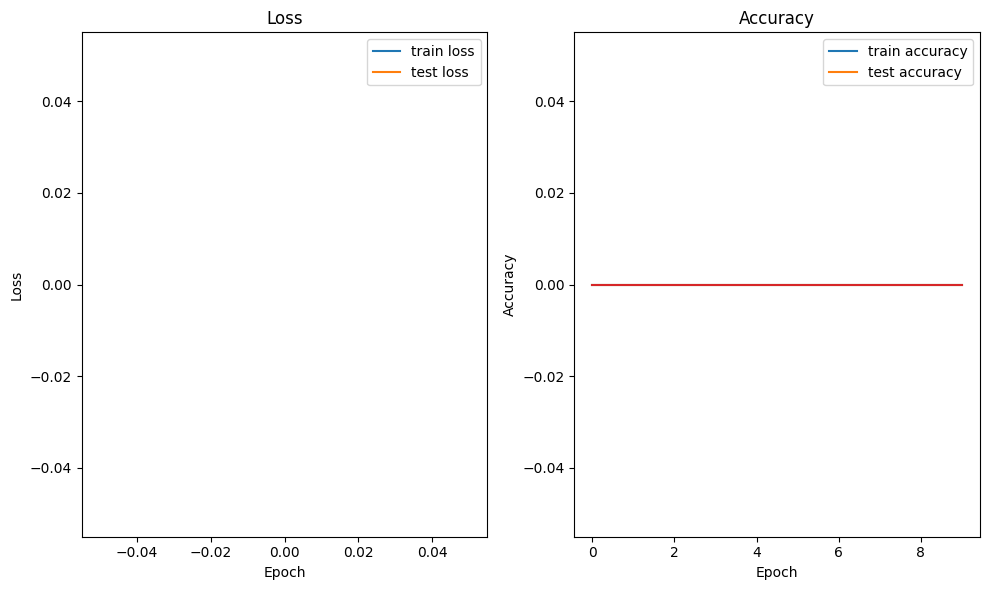

In [20]:
# Train the best model with all available data
best_model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb, early_stopping_cb])

# Get the history of the best model
best_model_history = best_model.history.history

# Plot the metrics of the best model
plot_graph_3([best_model_history])

In [ ]:
type(best_model_history)
for key in (best_model_history):
  print('[key]: ', key)



[key]:  loss
[key]:  val_loss
